#**DEEP LEARNING PROJECT**

This project was carried out by: Alessia Marisa Antognini (ID: 5309511) and Isabella Bonetto (ID: 5311154)

https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c

Medical imaging techniques, such as Magnetic Resonance Imaging (MRI), are a fundamental resource for the diagnosis and monitoring of numerous diseases, particularly those related to the central nervous system. This project focuses on the analysis of a dataset of brain MRI images, divided into 44 classes, each representing a specific type of brain tumor. The main objectives of the project are twofold:

1. Reconstruction of the images through the implementation of an autoencoder.
2. Classification of tumors by freezing the weights of the pre-trained encoder.


Accurate and early diagnosis of brain tumors is crucial to improving treatment outcomes and survival rates. This project aims to support medical professionals by automating tumor classification and enhancing the quality of diagnostic images using deep learning techniques, making the analysis faster and more accurate.

In [ ]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
pip install d2l==1.0.0a1.post0

In [ ]:
import torch
import random
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from google.colab import drive
import os
from d2l import torch as d2l
import torch
from torch import nn, optim
from torch.nn import Conv2d, ConvTranspose2d
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
from PIL import Image
from collections import defaultdict, Counter
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/My Drive/DL_progetto/progetto_DL_2024'

Our project focuses on the analysis of a dataset of brain magnetic resonance imaging (MRI) scans, divided into **44 classes** representing **14 types of brain tumors and 1 class of normality**. Each tumor is further divided into three subclasses based on the type of MRI sequence used to acquire the images: T1, T1 contrast-enhanced (T1-CE), and T2. For the normal class, however, only T1 and T2 are present because T1C+ is performed only when a tumor is detected in the brain.

1. **T1 (weighted imaging)**: This sequence produces high-resolution images that emphasize the contrast between different brain tissue structures. It is particularly useful for assessing the overall brain anatomy and identifying structural abnormalities such as tumors or edema.
2. **T1 contrast-enhanced (T1-CE):** This variant of the T1 sequence uses a contrast agent, such as gadolinium, to highlight areas with abnormal vascularization. It is especially effective in improving tumor visibility and distinguishing between active and non-active lesions.
3. **T2 (weighted imaging):** The T2 sequence emphasizes the water content in brain structures. It is particularly helpful in detecting edema, cysts, and inflammatory lesions, as fluids appear bright in these images.


We decided to combine the T1, T1-CE and T2 subclasses into a single representation for each tumor type for several reasons. This approach allows the model to utilize a larger amount of data, enhancing generalization and reducing the risk of overfitting, especially for classes with fewer samples. Additionally, the different MRI sequences provide complementary information about the same pathological condition, enabling the model to learn more robust and comprehensive representations. From a clinical perspective, the primary goal is to distinguish between tumor types regardless of the MRI sequence used, making this combination more aligned with practical diagnostic applications in the medical field.

In [ ]:
#15 classes
items = os.listdir(path)

folders = [item for item in items if os.path.isdir(os.path.join(path, item))]

print("The folders inside 'progetto_DL_2024' are:")
for folder in folders:
  print(f"  - {folder}")

num_folders = len(folders)

print(f"There are {num_folders} folders inside 'progetto_DL_2024'")

The folders inside 'progetto_DL_2024' are:
  - Glioblastoma
  - Tuberculoma
  - Oligodendroglioma
  - Schwannoma
  - Granuloma
  - _NORMAL
  - Medulloblastoma
  - Papilloma
  - Neurocytoma
  - Meningioma
  - Carcinoma
  - Astrocytoma
  - Germinoma
  - Ependymoma
  - Gangliocytoma
There are 15 folders inside 'progetto_DL_2024'


#**1.** **Autoencoder**

We converted the images into tensors as input for the autoencoder and experimented with data augmentation to add variability, but observed a low test accuracy.

In [ ]:
#Transformation of the images into tensor
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

g = torch.Generator()
g.manual_seed(seed)

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root=path, transform=transform)

dataloader = DataLoader(dataset, batch_size=32, shuffle=False, generator=g)

print(f"Number of the dataset's images: {len(dataset)}")

Number of the dataset's images: 4479


In [ ]:
#Attempt of data augmentation:

#transform = transforms.Compose([
    #transforms.Resize((64,64)),
    #transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.9, 1.1)),
    #transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    #transforms.RandomHorizontalFlip(p=0.2),
    #transforms.RandomRotation(5),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.0, hue=0.0),
    #transforms.ToTensor()
#])

In [ ]:
#Shape of the image
for img, _ in dataloader:
    print("Image's shape:", img.shape)
    break

Image's shape: torch.Size([32, 3, 64, 64])


We implemented an **autoencoder** architecture based on a convolutional neural network (CNN), divided into two main components: an encoder and a decoder.
1. The purpose of **encoder** is to reduce the dimensionality of the images and compress the relevant information into a compact representation known as the latent space. In our project, the encoder consists of two convolutional layers followed by max pooling operations, which progressively reduce the spatial dimensions of the images while preserving the most significant features.
2. The **decoder**, on the other hand, is designed to reconstruct the original image from the compressed latent space, using two transposed convolutional layers to restore the initial dimensions of the image and ensure the most accurate reconstruction possible.

In [ ]:
#Definition of the class Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

Below is the shape in each step of the autoencoder.

In [ ]:
#Inizialization and the architecture of autoencoder
net = Autoencoder()

net.eval()

print("Layer and size output during encoding:")
for X, _ in dataloader:
    for layer in net.encoder:
        X = layer(X)
        print(layer.__class__.__name__, 'Output shape:', X.shape)
    break

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
print("Device used:", device)
net.to(device)

print("\nArchitecture of the model:")
print(net)

Layer and size output during encoding:
Conv2d Output shape: torch.Size([32, 16, 64, 64])
ReLU Output shape: torch.Size([32, 16, 64, 64])
MaxPool2d Output shape: torch.Size([32, 16, 32, 32])
Conv2d Output shape: torch.Size([32, 8, 32, 32])
ReLU Output shape: torch.Size([32, 8, 32, 32])
MaxPool2d Output shape: torch.Size([32, 8, 16, 16])
Using device: cpu
Device used: cpu

Architecture of the model:
Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2,

After defining and initializing the autoencoder architecture, we implemented the **training process** with an early stopping strategy to prevent overfitting and ensure better model generalization. To optimize convergence and stability, the model parameters were initialized using **Kaiming initialization**, which is effective for networks utilizing the ReLU activation function.

During training, we employed **Mean Squared Error (MSE)** as the loss function, ideal for measuring the difference between original and reconstructed images, and the **Adam optimizer** to efficiently update the weights. The loss monitoring revealed a rapid initial decline, followed by stabilization, with the model achieving optimal learning before early stopping. This demonstrated a good balance between accuracy and overfitting prevention.

As can be seen from the obtained graph, early stopping stopped the training process at the **14th epoch**, well before the originally planned 50 epochs.

Epoch 14, Train Loss: 0.0029
Epochs without improvement: 5
Early stopping activated at the time 14. Best loss: 0.0034
Training completed!


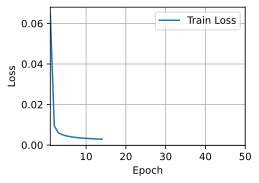

In [ ]:
#Training of autoencoder
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True, generator=torch.Generator().manual_seed(seed))

def reset_parameters(model):

    def init_weights(m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')  # Kaiming initialization for ReLU
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    model.apply(init_weights)


def train_epoch(net, train_iter, loss, updater, device):
    net.train()
    total_loss = 0
    for i, (X, _) in enumerate(train_iter):
        X = X.to(device)
        updater.zero_grad()
        Z = net.encoder(X)
        X_hat = net.decoder(Z)
        l = loss(X_hat, X)
        l.backward()
        updater.step()
        total_loss += l.item()
        print(f"Batch {i + 1}: Loss = {l.item():.4f}")
    return total_loss / len(train_iter)


def train(net, train_iter, loss, num_epochs, updater, device, patience=5, min_delta=0.001):

    best_loss = float('inf')
    loss_values = []
    wait = 0

    animator = d2l.Animator(xlabel='Epoch', ylabel='Loss', xlim=[1, num_epochs], legend=['Train Loss'])

    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, device)
        loss_values.append(train_loss)
        animator.add(epoch + 1, [train_loss])
        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}")

        # Early Stopping
        if train_loss < best_loss - min_delta:
            best_loss = train_loss
            wait = 0
        else:
            wait += 1
            print(f"Epochs without improvement: {wait}")
            if wait >= patience:
                print(f"Early stopping activated at the time {epoch + 1}. Best loss: {best_loss:.4f}")
                break

    print("Training completed!")
    return loss_values


reset_parameters(net)

lr, num_epochs = 0.001, 50


loss = nn.MSELoss()
trainer = optim.Adam(net.parameters(), lr=lr)


net.to(device)


loss_values = train(
    net=net,
    train_iter=dataloader,
    loss=loss,
    num_epochs=50,
    updater=trainer,
    device=device,
    patience=5,
    min_delta=0.001
)

In [ ]:
#Model saving
autoencoder_path = '/content/drive/My Drive/DL_progetto/autoencoder.pth'

torch.save(net.state_dict(), autoencoder_path)

print(f"Autoencoder model saved in: {autoencoder_path}")

Autoencoder model saved in: /content/drive/My Drive/DL_progetto/autoencoder.pth


In [ ]:
#Autoencoder loading
autoencoder_path = '/content/drive/My Drive/DL_progetto/autoencoder.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Autoencoder()
net.load_state_dict(torch.load(autoencoder_path))
net.eval()

<ipython-input-58-9a645ee8713a>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(autoencoder_path))


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)

With this code, we disable gradient calculations using with torch.no_grad() because we are in the inference phase, not during training. Our goal is to obtain the representations Z generated by the encoder at the final epoch of the trained model. These representations Z are then used as input for the decoder, which reconstructs the original images (X_hat).

Finally, the code checks that the dimension of the latent space Z (obtained at the last step of the encoder) matches the expected dimension defined in the project, ensuring that the model is functioning correctly in terms of tensor dimensions.

In [ ]:
#Visualization of Latent Space and Image Reconstruction
net.to(device)

with torch.no_grad():
    for X, _ in dataloader:
        X = X.to(device)
        Z = net.encoder(X)
        X_hat = net.decoder(Z)
        break

print("Z shape:", Z.shape)

Z shape: torch.Size([32, 8, 16, 16])


We have decided to represent the original images used as input (X) and compare them with the reconstructed images (X_hat).

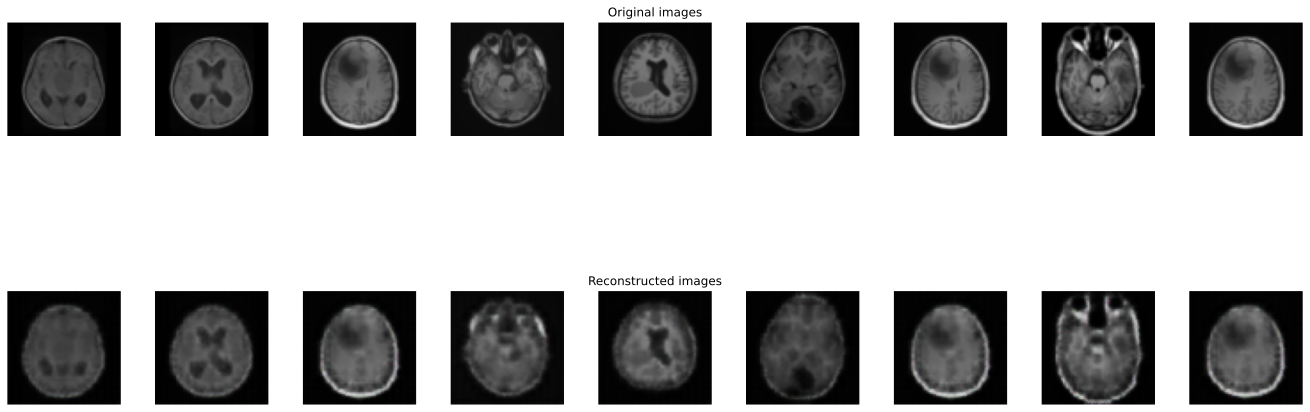

In [ ]:
#Original images vs reconstructed images
net.eval()


with torch.no_grad():
    for X, _ in dataloader:
        X = X.to(device)
        X_hat = net(X)
        break

demo_imgs = 9

fig, ax = plt.subplots(2, demo_imgs, figsize=(20, 8))

for i in range(demo_imgs):

    ax[0, i].imshow(X[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('off')

    ax[1, i].imshow(X_hat[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].axis('off')

plt.setp(ax[0, demo_imgs // 2], title='Original images')
plt.setp(ax[1, demo_imgs // 2], title='Reconstructed images')

plt.subplots_adjust(bottom=0.1, left=0.05, right=0.95, top=0.9, wspace=0.3, hspace=0.4)

plt.show()

#**2.** **Classification**





At this point, we move on to the **classification** phase of the project. We began by printing the label and the number of images for each class. This analysis revealed an imbalance in the distribution of classes within the dataset. To address this, we calculated weights inversely proportional to the frequency of each class, ensuring a more balanced contribution during the training process.


Next, we split the dataset into **training**, **validation** and **test sets**, allocating 80%, 10%, and 10% of the total data, respectively, to ensure robust model evaluation and fine-tuning.

In [ ]:
#Representation of class, label and number of images
labels = [label for _, label in dataset]

class_counts = Counter(labels)

class_mapping = dataset.classes

for label, count in class_counts.items():
    print(f"Class: {class_mapping[label]}, Label: {label}, Number of images: {count}")

Class: Astrocytoma, Label: 0, Number of images: 580
Class: Carcinoma, Label: 1, Number of images: 251
Class: Ependymoma, Label: 2, Number of images: 150
Class: Gangliocytoma, Label: 3, Number of images: 61
Class: Germinoma, Label: 4, Number of images: 100
Class: Glioblastoma, Label: 5, Number of images: 204
Class: Granuloma, Label: 6, Number of images: 78
Class: Medulloblastoma, Label: 7, Number of images: 131
Class: Meningioma, Label: 8, Number of images: 874
Class: Neurocytoma, Label: 9, Number of images: 457
Class: Oligodendroglioma, Label: 10, Number of images: 224
Class: Papilloma, Label: 11, Number of images: 237
Class: Schwannoma, Label: 12, Number of images: 465
Class: Tuberculoma, Label: 13, Number of images: 145
Class: _NORMAL, Label: 14, Number of images: 522


In [ ]:
#Number of images ofr the training, validation and test sets.
labels = [label for _, label in dataset]
class_counts = Counter(labels)

num_classes = len(class_counts)
class_weights = [1.0 / class_counts[i] for i in range(num_classes)]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

class_to_indices = defaultdict(list)
for idx, (_, label) in enumerate(dataset):
    class_to_indices[label].append(idx)

train_indices, val_indices, test_indices = [], [], []
for class_indices in class_to_indices.values():
    random.shuffle(class_indices)
    train_count = int(0.8 * len(class_indices))
    val_count = int(0.1 * len(class_indices))
    train_indices.extend(class_indices[:train_count])
    val_indices.extend(class_indices[train_count:train_count + val_count])
    test_indices.extend(class_indices[train_count + val_count:])


train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


print(f"Number of images in the training ift: {len(train_dataset)}")
print(f"Number of images in the validation if: {len(val_dataset)}")
print(f"Number of images in the test if: {len(test_dataset)}")

Number of images in the training ift: 3578
Number of images in the validation if: 443
Number of images in the test if: 458


In this part we analyzed a randomly selected batch from the train_loader and prints the numerical labels (y) associated with the images in the batch, along with their corresponding class names using the mapping defined in dataset.classes. It is useful for verifying the correct association between numerical labels and their respective classes in the dataset.


In [ ]:
#Association between numerical lables and their respective classes
for X, y in train_loader:
    print(f"Batch labels: {y}")
    for label in y:
        print(f"Associated class: {dataset.classes[label]}")
    break

Batch labels: tensor([ 8,  5,  8,  9, 12,  7, 10, 11,  5, 12,  9, 14, 14,  1,  5,  8,  0,  2,
         2, 14,  8,  9, 14,  0,  8,  0,  9,  0, 13,  0,  9,  9])
Associated class: Meningioma
Associated class: Glioblastoma
Associated class: Meningioma
Associated class: Neurocytoma
Associated class: Schwannoma
Associated class: Medulloblastoma
Associated class: Oligodendroglioma
Associated class: Papilloma
Associated class: Glioblastoma
Associated class: Schwannoma
Associated class: Neurocytoma
Associated class: _NORMAL
Associated class: _NORMAL
Associated class: Carcinoma
Associated class: Glioblastoma
Associated class: Meningioma
Associated class: Astrocytoma
Associated class: Ependymoma
Associated class: Ependymoma
Associated class: _NORMAL
Associated class: Meningioma
Associated class: Neurocytoma
Associated class: _NORMAL
Associated class: Astrocytoma
Associated class: Meningioma
Associated class: Astrocytoma
Associated class: Neurocytoma
Associated class: Astrocytoma
Associated class:

Below, we defined the **classifier**, which includes the pre-trained encoder, a flattening layer and a fully connected (FC) network.
- To leverage the pre-trained encoder of the autoencoder, we froze its weights (using the torch.no_grad() function), ensuring that they do not contribute to gradient updates (of the classifier) during training.
- The FC network consists of three dense layers:
  - interspersed with ReLU activations
  - batch normalization to improve convergence
  - dropout layers to reduce overfitting.
  
  These layers are responsible for learning the decision boundaries needed to classify the 15 classes in the dataset.
  
- During the forward pass, the encoder remains frozen, extracting the latent representations Z, which are then flattened and passed through the FC layers to produce the final class predictions.

The classifier was initialized with the encoder and the specified number of classes. The optimizer was configured with two different learning rates:
- a lower one for the encoder, to preserve the learned features
-
a higher one for the FC layers, enabling effective learning during classification.

Finally, we defined the loss function using CrossEntropyLoss with class-specific weights. These weights, calculated based on the inverse frequency of each class, ensure that the model accounts for the imbalance among classes, improving its ability to generalize across all categories.

In [ ]:
#Definition of the class Classifier
for param in net.encoder.parameters():
    param.requires_grad = False


class Classifier(nn.Module):
    def __init__(self, encoder, num_classes):
        super(Classifier, self).__init__()
        self.encoder = encoder
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
          nn.Linear(8 * 16 * 16, 256),
          nn.ReLU(),
          nn.BatchNorm1d(256),
          nn.Dropout(0.5),
          nn.Linear(256, 128),
          nn.ReLU(),
          nn.BatchNorm1d(128),
          nn.Dropout(0.5),
          nn.Linear(128, num_classes)
        )

    def forward(self, x):
        with torch.no_grad():
            z = self.encoder(x)
        z = self.flatten(z)
        out = self.fc(z)
        return out


num_classes = 15
classifier = Classifier(encoder=net.encoder, num_classes=num_classes).to(device)

optimizer = optim.Adam([
    {'params': classifier.encoder.parameters(), 'lr': 1e-5},
    {'params': classifier.fc.parameters(), 'lr': 1e-3}
])

criterion = nn.CrossEntropyLoss(weight=class_weights)

We monitored the train loss and train accuracy to evaluate the model's performance across epochs and we fixed the number of epochs equal to 50. The train loss graph shows a sharp initial decline, indicating rapid learning, followed by stabilization, demonstrating convergence. Similarly, significant improvements were observed in training accuracy.

To assess the model further, we also tracked its performance on the validation set. Early stopping was triggered at the 24th epoch when the model showed no significant improvements beyond the defined threshold.

Epoca 1, Train Loss = 263.4118, Train Accuracy = 19.42%, Val Loss = 26.6238, Val Accuracy = 42.21%
Epoca 2, Train Loss = 196.6058, Train Accuracy = 37.23%, Val Loss = 20.9560, Val Accuracy = 51.69%
Epoca 3, Train Loss = 156.5024, Train Accuracy = 49.11%, Val Loss = 17.1679, Val Accuracy = 63.43%
Epoca 4, Train Loss = 131.4177, Train Accuracy = 56.85%, Val Loss = 14.6587, Val Accuracy = 66.59%
Epoca 5, Train Loss = 116.9256, Train Accuracy = 60.68%, Val Loss = 13.1197, Val Accuracy = 72.46%
Epoca 6, Train Loss = 97.0271, Train Accuracy = 66.69%, Val Loss = 12.4420, Val Accuracy = 71.33%
Epoca 7, Train Loss = 84.3952, Train Accuracy = 69.26%, Val Loss = 10.7284, Val Accuracy = 77.88%
Epoca 8, Train Loss = 78.5806, Train Accuracy = 70.49%, Val Loss = 9.6968, Val Accuracy = 78.78%
Epoca 9, Train Loss = 70.2619, Train Accuracy = 73.90%, Val Loss = 8.3140, Val Accuracy = 84.20%
Epoca 10, Train Loss = 67.4300, Train Accuracy = 74.43%, Val Loss = 8.6586, Val Accuracy = 82.17%
Epoca 11, Train L

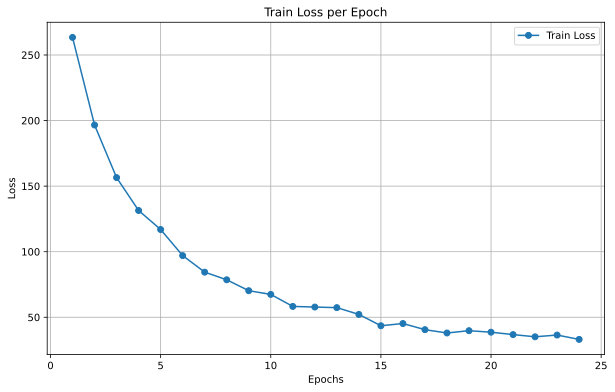

In [ ]:
#Training of the classifier
optimizer = optim.Adam([
    {'params': classifier.encoder.parameters(), 'lr': 1e-5},
    {'params': classifier.fc.parameters(), 'lr': 1e-3}
])

train_losses = []
train_accuracies = []

patience = 10
min_delta = 1
wait = 0
best_val_loss = float('inf')


num_epochs = 50
for epoch in range(num_epochs):
    classifier.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = classifier(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = outputs.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()

    train_losses.append(epoch_loss)
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)


    classifier.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            outputs = classifier(X)
            val_loss += criterion(outputs, y).item()
            _, predicted = outputs.max(1)
            val_total += y.size(0)
            val_correct += predicted.eq(y).sum().item()

    val_accuracy = 100 * val_correct / val_total

    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping activated at the time {epoch + 1}. Best Val Loss: {best_val_loss:.4f}")
            break

    print(f"Epoca {epoch + 1}, Train Loss = {epoch_loss:.4f}, Train Accuracy = {train_accuracy:.2f}%, Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.2f}%")


plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Model saving
classifier_path = '/content/drive/My Drive/DL_progetto/classifier.pth'
torch.save(classifier.state_dict(), classifier_path)
print(f"Classifier model saved in: {classifier_path}")

Classifier model saved in: /content/drive/My Drive/DL_progetto/classifier.pth


In [ ]:
#Model loading
classifier_path = '/content/drive/My Drive/DL_progetto/classifier.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classifier = Classifier(encoder=net.encoder, num_classes=num_classes).to(device)
classifier.load_state_dict(torch.load(classifier_path))
classifier.eval()

<ipython-input-23-94d64112850c>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(classifier_path))


Classifier(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=128, out_features=15, bias=True)
  )
)

We subsequently evaluated the classifier's performance on the **test set**, calculating both the overall test loss and accuracy. For each batch, the images and their true labels were processed by the classifier to generate predictions, and the loss was computed against the true labels using the criterion function. Accuracy was determined by comparing the predicted classes with the true ones. The test accuracy of **89.74%** indicates that the model has a good ability to generalize to unseen data.

In [ ]:
#Test loss and accuracy
classifier.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        outputs = classifier(X)
        test_loss += criterion(outputs, y).item()
        _, predicted = outputs.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()

test_accuracy=100 * correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 6.0075, Test Accuracy: 89.74%


After obtaining the results, we aimed to graphically represent the train and test accuracy.

From the graph, it can be observed that the Train Accuracy steadily improves during the initial epochs, reaching convergence towards the end of the training process. This suggests that the model effectively learned from the training data. The Test Accuracy is represented by a horizontal red line and remains relatively close to the Train Accuracy. This outcome indicates that the model generalizes well on unseen data, maintaining a performance level similar to that achieved on the training set.

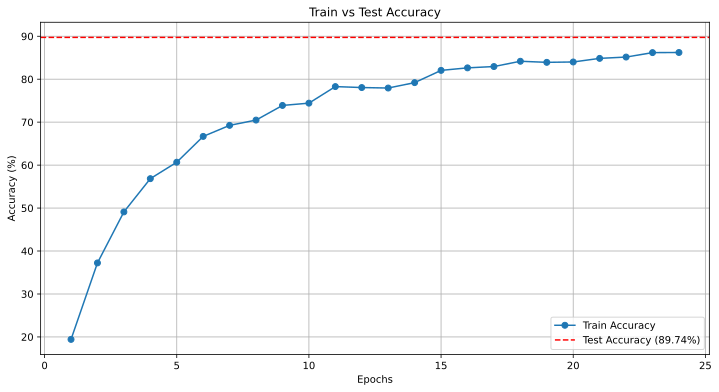

In [ ]:
#Plot of Train vs Test Accuracy
epochs = range(1, len(train_accuracies) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracies, label="Train Accuracy", marker='o')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label=f"Test Accuracy ({test_accuracy:.2f}%)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()

We analyzed the classifier's performance on the test set by selecting one representative image for each class, displaying both the true label and the predicted label. The model was set to evaluation mode and processed a batch of images from the test set, generating predictions for each class.
The selected images were then prepared and visualized, highlighting both correct predictions and misclassifications.

The output shows that the model is able to correctly classify many of the classes but also reveals some misclassifications. For instance, "Astocytoma" was mistakenly classified as "Gangliocytoma" and "Medulloblastoma" was misclassified as "Meningioma."

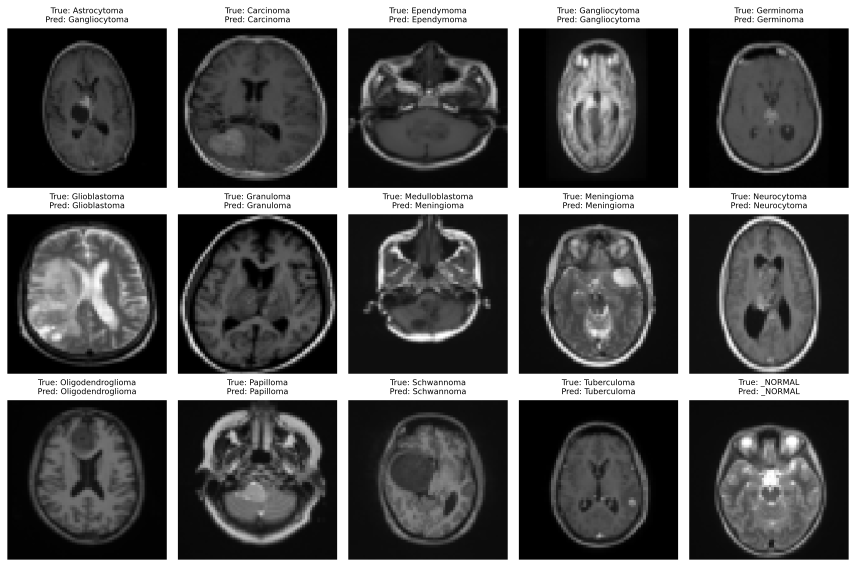

In [ ]:
#True images vs predicted images
classifier.eval()

class_samples = {class_name: [] for class_name in dataset.classes}

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        outputs = classifier(X)
        _, predicted = outputs.max(1)

        X = X.cpu().numpy()
        y = y.cpu().numpy()
        predicted = predicted.cpu().numpy()

        for i in range(len(X)):
            true_label = dataset.classes[y[i]]
            if len(class_samples[true_label]) < 1:
                image = X[i].transpose((1, 2, 0))
                image = np.clip(image, 0, 1)
                class_samples[true_label].append((image, true_label, dataset.classes[predicted[i]]))

        if all(len(v) >= 1 for v in class_samples.values()):
            break

plt.figure(figsize=(12, 8))
for i, (class_name, samples) in enumerate(class_samples.items()):
    if samples:
        image, true_label, pred_label = samples[0]
        plt.subplot(3, 5, i + 1)
        plt.imshow(image)
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=8)
        plt.axis('off')

plt.tight_layout()
plt.show()

We decided to analyze the performance of our classifier by plotting both the **confusion matrix** and a table summarizing the main evaluation metrics: **precision**, **recall** and **F1-score**.

Regarding the confusion matrix, some significant errors emerge, particularly  Astrocytoma is considered as Neurocytoma for 4 times and Meningioma is classified as Astrocytoma for 5 times. Nevertheless, for many classes, the model demonstrated a strong ability to correctly distinguish the actual labels from the predicted ones.

The analysis of the main metrics provides further insights into the model's performance:

- Precision is high for classes such as *Germinoma* (1.000), *Ependymoma* (1.000), and *Granuloma* (1.000), indicating that the model is very accurate in predicting these classes.
- Recall is high for the majority of the classes, meaning the model identifies almost all samples belonging to these classes. This happens because of their smaller support.
- F1-score, which balances precision and recall, is very high for classes such as *Schwannoma* (0.959), *Papilloma* (0.980) and *Glioblastoma* (0.977), demonstrating good overall performance for these classes.

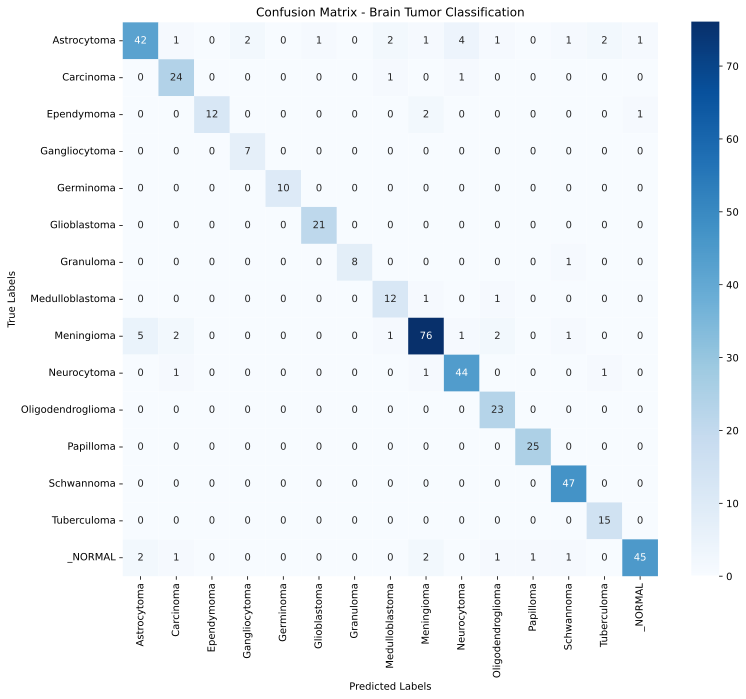

                   precision    recall  f1-score   support

      Astrocytoma      0.857     0.724     0.785        58
        Carcinoma      0.828     0.923     0.873        26
       Ependymoma      1.000     0.800     0.889        15
    Gangliocytoma      0.778     1.000     0.875         7
        Germinoma      1.000     1.000     1.000        10
     Glioblastoma      0.955     1.000     0.977        21
        Granuloma      1.000     0.889     0.941         9
  Medulloblastoma      0.750     0.857     0.800        14
       Meningioma      0.916     0.864     0.889        88
      Neurocytoma      0.880     0.936     0.907        47
Oligodendroglioma      0.821     1.000     0.902        23
        Papilloma      0.962     1.000     0.980        25
       Schwannoma      0.922     1.000     0.959        47
      Tuberculoma      0.833     1.000     0.909        15
          _NORMAL      0.957     0.849     0.900        53

         accuracy                          0.897      

In [ ]:
#Confusion matrix and table with metrics
classifier.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        outputs = classifier(X)
        _, preds = outputs.max(1)
        true_labels.extend(y.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

cm = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=dataset.classes, yticklabels=dataset.classes
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Brain Tumor Classification')
plt.show()

report = classification_report(true_labels, predicted_labels, target_names=dataset.classes, digits=3)
print(report)

save_path = "/content/drive/My Drive/DL_progetto/classification_report.txt"  # Modifica il percorso se necessario
with open(save_path, "w") as file:
    file.write(report)

print(f"Classification report saved in: {save_path}")

Our deep learning model has achieved an accuracy of **89.74%** in **classifying brain tumor types** based on magnetic resonance imaging (MRI) scans. This result is significant, as our research (https://www.mdpi.com/2075-4418/14/16/1791) indicates that the accuracy of physicians in diagnosing brain tumors through MRI is comparable to that of our model.

By integrating this model into the early stages of diagnosis, physicians can benefit from an automated second opinion, which could help reduce errors and optimize clinical decision-making.

We believe that collaboration between artificial intelligence and human expertise offers promising prospects for diagnostic medicine, enhancing precision and efficiency in the treatment of brain tumors.



